# IMPORT LIBRARIES

In [1]:
import tkinter as tk
from tkinter import ttk, messagebox, filedialog, simpledialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.api as sm
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf


# EXTRACT DATA AND PERFORM TEST

Model has been assigned to the instance variable.

ANOVA Results:
                sum_sq    df           F        PR(>F)
C(gender)   282.262064   1.0  425.529518  6.329098e-24
C(drug)      84.616785   2.0   63.782818  1.361143e-13
C(sadness)   16.763208   1.0   25.271692  9.262529e-06
Residual     28.522742  43.0         NaN           NaN

Model Summary
                            OLS Regression Results                            
Dep. Variable:                   pain   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     144.6
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           2.43e-24
Time:                        15:50:08   Log-Likelihood:                -55.617
No. Observations:                  48   AIC:                             121.2
Df Residuals:                      43   BIC:                             130.6
Df Model:   

<Figure size 800x600 with 0 Axes>

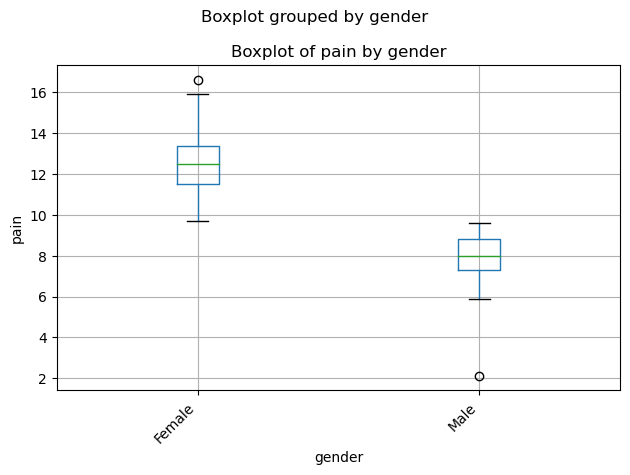

<Figure size 800x600 with 0 Axes>

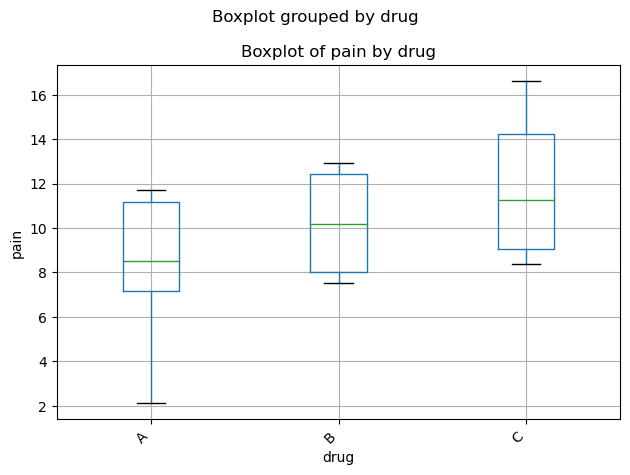

<Figure size 800x600 with 0 Axes>

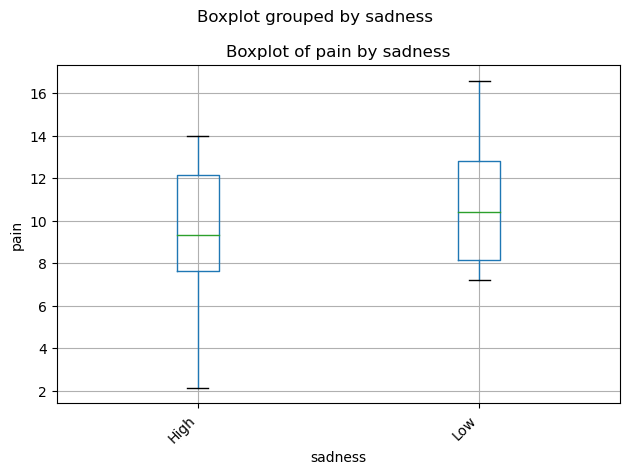

Error plotting interaction effects: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error converting data to categorical: observation with value 'Male' does not match any of the expected levels (expected: ['A', 'B', 'C'])
    pain ~ C(gender) + C(drug) + C(sadness)
                       ^^^^^^^


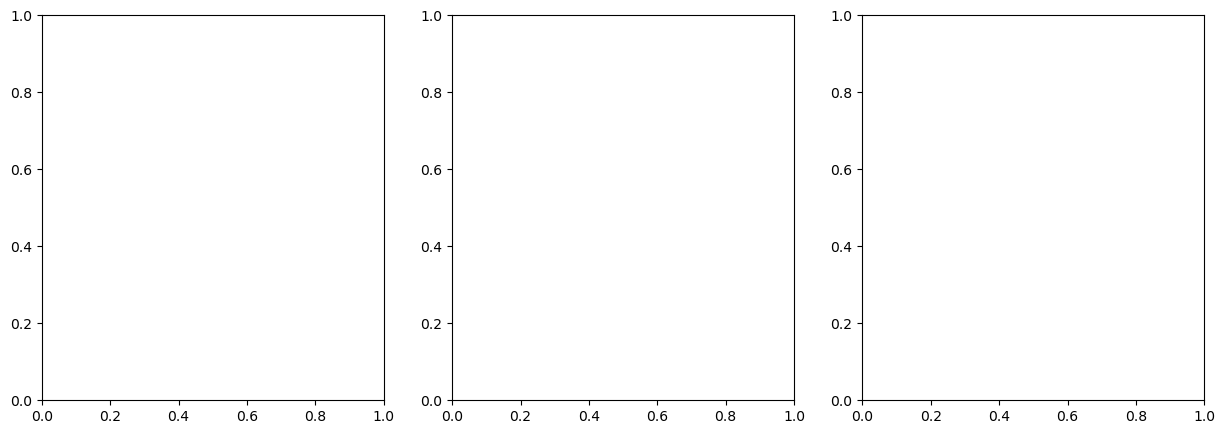

In [2]:
# Global variables
df = None
factors = []
response = None
window = None
analysis_performed = False


class n_way_ANOVA_App(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("n-Way ANOVA for Categorical Data")
        self.geometry("400x500")  # Adjusted the size for better layout
        self.df = None
        self.model = None
        self.response_var = tk.StringVar()
        self.num_groups_var = tk.IntVar(value=1)  # Initialize with 1 factor
        self.column_comboboxes = []  # Initialize the list for factor comboboxes

        self.create_widgets()

    def create_widgets(self):
        ttk.Label(self, text="Select Excel File:").grid(row=0, column=0, columnspan=2, sticky='w', padx=10, pady=5)
        self.file_path_entry = ttk.Entry(self, width=28)
        self.file_path_entry.grid(row=1, column=0, padx=10, pady=5)
        load_button = ttk.Button(self, text="Load File", command=self.load_file)
        load_button.grid(row=1, column=1, padx=10, pady=5)

        ttk.Label(self, text="Number of factors:\n(Hit Enter key to update number)").grid(row=2, column=0, sticky='w', padx=10, pady=5)
        num_groups_spinbox = ttk.Spinbox(self, from_=1, to=10, wrap=True, width=7, textvariable=self.num_groups_var)
        num_groups_spinbox.grid(row=2, column=1, padx=10, pady=5)
        num_groups_spinbox.bind('<Return>', self.update_column_comboboxes)
        num_groups_spinbox.bind('<<Increment>>', self.update_column_comboboxes)
        num_groups_spinbox.bind('<<Decrement>>', self.update_column_comboboxes)

        
        # Ensure this label is correctly positioned and visible
        ttk.Label(self, text="Select Factors:").grid(row=3, column=0, columnspan=2, sticky='w', padx=10, pady=5)
        self.update_column_comboboxes()  # Adjust the start row inside this method accordingly


        ttk.Label(self, text="Select Response Variable:").grid(row=100, column=0, columnspan=2, sticky='w', padx=10, pady=5)
        self.response_combobox = ttk.Combobox(self, width=27, textvariable=self.response_var, state="readonly")
        self.response_combobox.grid(row=101, column=0, columnspan=2, padx=10, pady=5)



        anova_button = ttk.Button(self, text="Perform Analysis", command=self.perform_analysis)
        anova_button.grid(row=102, column=0, columnspan=2, padx=10, pady=5, sticky='ew')

        self.status_label = ttk.Label(self, text="")
        self.status_label.grid(row=103, column=0, columnspan=2, sticky='ew', padx=10, pady=5)


    def load_file(self):
        file_path = filedialog.askopenfilename(title="Select Excel File", filetypes=[("Excel files", "*.xlsx"), ("All files", "*.*")])
        if file_path:
            self.file_path_entry.delete(0, tk.END)
            self.file_path_entry.insert(0, file_path)
            self.df = self.read_excel_file(file_path)
            self.update_response_and_factor_comboboxes()

    def read_excel_file(self, file_path):
        try:
            df = pd.read_excel(file_path)
            df.dropna(axis=1, how='all', inplace=True)
            return df
        except Exception as e:
            messagebox.showerror("Error", f"Failed to read the file due to: {e}")
            return None

    def update_response_and_factor_comboboxes(self):
        if self.df is not None:
            columns = list(self.df.columns)
            self.response_combobox['values'] = columns
            if columns:
                self.response_combobox.current(0)
            self.update_column_comboboxes()

    def update_column_comboboxes(self, event=None):
        for combobox in self.column_comboboxes:
            combobox.grid_forget()
        self.column_comboboxes = []
        num_factors = self.num_groups_var.get()
        for i in range(num_factors):
            combobox = ttk.Combobox(self, values=[], state="readonly")
            combobox.grid(row=4+i, column=0, columnspan=2, padx=10, pady=2, sticky='ew')
            self.column_comboboxes.append(combobox)
        if self.df is not None:
            self.update_group_selection(self.df.columns)

    def update_group_selection(self, columns):
        for combobox in self.column_comboboxes:
            combobox['values'] = list(columns)
            if len(columns) > 0:
                combobox.current(0)

    
    def perform_analysis(self):
        selected_columns = [combobox.get() for combobox in self.column_comboboxes if combobox.get()]
        if not selected_columns:
            messagebox.showerror("Error", "Please select valid columns for analysis.")
            return

        self.perform_n_way_anova(selected_columns)
        self.plot_boxplot(selected_columns)
        self.plot_interaction_nway(selected_columns)
        


    def perform_n_way_anova(self, selected_columns):
        if self.df is None or self.df.empty:
            messagebox.showerror("Error", "Dataframe not loaded or not enough factors selected.")
            return None

        try:
            response = self.response_var.get()
            factors = selected_columns
            if response not in self.df.columns or self.df[response].dtype not in [np.float64, np.int64]:
                messagebox.showerror("Error", "Invalid response variable. It must be numeric.")
                return None
            
            formula = f"{response} ~ " + " + ".join([f"C({factor})" for factor in factors])
            self.model = smf.ols(formula, data=self.df).fit()
            print("Model has been assigned to the instance variable.")
            
            print("\nANOVA Results:")
            print(sm.stats.anova_lm(self.model, typ=2))
            print("\nModel Summary")
            print(self.model.summary())
            
        except Exception as e:
            messagebox.showerror("Error", f"Error performing n-way ANOVA: {e}")
            return None

        return self.model
        
    def plot_boxplot(self, selected_columns):
        if self.df is None or self.df.empty:
            print("DataFrame is empty.")
            return

        response = self.response_var.get()
        factors = selected_columns

        for factor in factors:
            plt.figure(figsize=(8, 6))
            self.df.boxplot(column=response, by=factor)
            plt.title(f'Boxplot of {response} by {factor}')
            plt.xlabel(factor)
            plt.ylabel(response)
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()
   

    def plot_interaction_nway(self, selected_columns):
        if self.model is None:
            print("Model not found. Please perform ANOVA first.")
            return
        
        try:
            response = self.response_var.get()
            factors = selected_columns
            
            fig, axes = plt.subplots(nrows=1, ncols=len(factors), figsize=(15, 5))
            if len(factors) == 1:  # Handling the case when there's only one factor
                axes = [axes]
                
            for i, factor in enumerate(factors):
                factor_levels = self.df[factor].unique()
                dummy_data = pd.DataFrame(list(itertools.product(*[self.df[factor].unique() for _ in factors])), columns=factors)
                
                predictions = self.model.predict(exog=dummy_data)
                
                # Ensuring the factor is treated as a categorical variable
                dummy_data[factor] = dummy_data[factor].astype(str)
                
                axes[i].plot(dummy_data[factor], predictions, marker='o')
                axes[i].set_title(f"Interaction with {str(factor)}")  # Ensuring title is always a string
                axes[i].set_xlabel(str(factor))  # Ensuring xlabel is always a string
                axes[i].set_ylabel(str(response))  # Ensuring ylabel is always a string

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting interaction effects: {e}")


if __name__ == "__main__":
    app = n_way_ANOVA_App()
    app.mainloop()
